In [1]:
# === Cell 0: Installs (nếu cần) ===
!pip -q install "transformers>=4.40.0" "accelerate>=0.31.0" "scikit-learn>=1.3.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 69.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.8 MB/s eta 0:00:00:00:0100:01
ERROR: pip's depen

In [2]:
# === Cell 1: Imports + CFG ===
import os, json, math, copy, random, zipfile
from dataclasses import dataclass
from typing import Optional, List, Dict

import numpy as np
import pandas as pd
from collections import Counter
from tqdm.auto import tqdm

from sklearn.metrics import f1_score, accuracy_score, classification_report
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ----------------- CONFIG -----------------
@dataclass
class CFG:
    # đường dẫn data gốc (raw train/test)
    train_csv: str = "/kaggle/input/dsc-uit-2025/vihallu-train.csv"
    test_csv:  str = "/kaggle/input/dsc-uit-2025/vihallu-private-test.csv"

    # dataset CE pipeline đã publish
    CE_DIR: str = "/kaggle/input/ce-gate-pipeline-v3-3"   

    # file tên trong dataset CE
    cov_train_mass: str = "hybrid_train_v3_coverage_with_mass.csv"
    cov_val_mass:   str = "hybrid_val_v3_coverage_with_mass.csv"
    cov_test_mass:  str = "hybrid_test_v3_coverage_with_mass.csv"   
    labels_json:    str = "labels.json"

    # cột
    id_col:  str = "id"
    prm_col: str = "prompt"
    rsp_col: str = "response"
    ctx_col: str = "context"
    lab_col: str = "label"

    # mô hình backbone cho classifier
    pretrained_cls: str = "vinai/phobert-large"     # có thể dùng "vinai/phobert-base"
    max_len: int = 256

    # train hyperparams
    batch_size: int = 8
    epochs: int = 8
    lr_backbone: float = 1e-5
    lr_head: float = 1e-4
    weight_decay: float = 0.01
    warmup_ratio: float = 0.1
    grad_clip: float = 1.0
    label_smoothing: float = 0.05
    rdrop_alpha: float = 0.5

    # EMA / FGM
    use_ema: bool = True
    ema_decay: float = 0.999
    use_fgm: bool = True
    fgm_eps: float = 0.5

    # Inference options
    do_temp_scale: bool = True
    do_tta: bool = False           # MC-Dropout TTA
    tta_passes: int = 8
    do_pseudo: bool = False        # pseudo-label fine-tune
    pseudo_conf_th: float = 0.90
    pseudo_epochs: int = 2
    do_ensemble: bool = False      # ensemble base + pseudo

    # IO
    outdir: str = "/kaggle/working/final_classifier"

    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

os.makedirs(CFG.outdir, exist_ok=True)

def seed_all(s=CFG.seed):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)
seed_all()

# Label maps (nếu labels.json không có)
LABEL2ID = {"no":0, "intrinsic":1, "extrinsic":2}
ID2LABEL = {v:k for k,v in LABEL2ID.items()}

# load mapping từ CE dataset nếu có
lbl_path = os.path.join(CFG.CE_DIR, CFG.labels_json)
if os.path.isfile(lbl_path):
    try:
        mp = json.load(open(lbl_path, "r"))
        if "LABEL2ID" in mp and "ID2LABEL" in mp:
            LABEL2ID = {k:int(v) for k,v in mp["LABEL2ID"].items()}
            ID2LABEL = {int(k):str(v) for k,v in mp["ID2LABEL"].items()}
    except:
        pass

print("LABEL2ID:", LABEL2ID)
print("ID2LABEL:", ID2LABEL)

LABEL2ID: {'no': 0, 'intrinsic': 1, 'extrinsic': 2}
ID2LABEL: {0: 'no', 1: 'intrinsic', 2: 'extrinsic'}


In [3]:
# === Cell 2: Load raw & coverage_with_mass + chuẩn hoá cột ===
def load_raw():
    tr = pd.read_csv(CFG.train_csv)
    te = pd.read_csv(CFG.test_csv)
    assert CFG.id_col in te.columns, f"Test phải có cột {CFG.id_col}"
    return tr, te

def _norm_cov_cols(df: pd.DataFrame, need_label: bool) -> pd.DataFrame:
    # yêu cầu cột cơ bản
    assert "id" in df.columns, "coverage thiếu cột id"
    assert "evidence" in df.columns, "coverage thiếu cột evidence"

    # mass columns: hỗ trợ cả neutral_cov và neutral_mass
    if "neutral_cov" not in df.columns and "neutral_mass" in df.columns:
        df = df.rename(columns={"neutral_mass": "neutral_cov"})
    for c in ["support_mass","conflict_mass","neutral_cov"]:
        assert c in df.columns, f"coverage thiếu cột {c}"
    # coverage metrics
    if "rougeL" not in df.columns:
        df["rougeL"] = 0.0
    if "uni_cov" not in df.columns and "uni_cov_ctx" in df.columns:
        df = df.rename(columns={"uni_cov_ctx":"uni_cov"})
    if "uni_cov" not in df.columns:
        df["uni_cov"] = 0.0
    # label cho train/val
    if need_label:
        assert "label" in df.columns, "coverage train/val thiếu cột label"
    return df

def load_coverage_with_mass():
    p_tr = os.path.join(CFG.CE_DIR, CFG.cov_train_mass)
    p_va = os.path.join(CFG.CE_DIR, CFG.cov_val_mass)
    p_te = os.path.join(CFG.CE_DIR, CFG.cov_test_mass)

    cov_tr = pd.read_csv(p_tr)
    cov_va = pd.read_csv(p_va)
    cov_te = pd.read_csv(p_te)

    cov_tr = _norm_cov_cols(cov_tr, need_label=True)
    cov_va = _norm_cov_cols(cov_va, need_label=True)
    cov_te = _norm_cov_cols(cov_te, need_label=False)

    print("[VAL] shapes:", cov_va.shape)
    print(cov_va[["support_mass","conflict_mass","neutral_cov","rougeL"]].describe().round(3))
    print("[TEST] shapes:", cov_te.shape)
    print(cov_te[["support_mass","conflict_mass","neutral_cov","rougeL"]].describe().round(3))

    return cov_tr, cov_va, cov_te

train_raw, test_raw = load_raw()
cov_tr, cov_va, cov_te = load_coverage_with_mass()

tok = AutoTokenizer.from_pretrained(CFG.pretrained_cls, use_fast=True)
print("Tokenizer:", CFG.pretrained_cls)

[VAL] shapes: (700, 9)
       support_mass  conflict_mass  neutral_cov   rougeL
count       700.000        700.000      700.000  700.000
mean          0.422          0.231        0.404    0.264
std           0.441          0.362        0.411    0.094
min           0.000          0.000        0.000    0.070
25%           0.005          0.000        0.002    0.203
50%           0.252          0.001        0.323    0.242
75%           0.996          0.498        0.875    0.294
max           1.000          0.999        0.999    0.962
[TEST] shapes: (2000, 8)
       support_mass  conflict_mass  neutral_cov    rougeL
count      2000.000       2000.000     2000.000  2000.000
mean          0.377          0.280        0.429     0.261
std           0.388          0.374        0.387     0.090
min           0.000          0.000        0.000     0.075
25%           0.010          0.000        0.009     0.203
50%           0.256          0.002        0.375     0.237
75%           0.752          0.54

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Tokenizer: vinai/phobert-large


In [4]:
# === Cell 3: Tokenizer + Dataset/Loader  ===
def _normalize_cov_cols(df_cov: pd.DataFrame) -> pd.DataFrame:
    df = df_cov.copy()
    if "neutral_mass" in df.columns and "neutral_cov" not in df.columns:
        df = df.rename(columns={"neutral_mass": "neutral_cov"})
    return df

def _sanitize_cov_for_merge(df_cov: pd.DataFrame) -> pd.DataFrame:
    df = _normalize_cov_cols(df_cov)
    drop_cols = [c for c in ["label", "predict_label"] if c in df.columns]
    if drop_cols:
        df = df.drop(columns=drop_cols)
    return df

def _unify_col_after_merge(m: pd.DataFrame, base: str) -> pd.DataFrame:
    x, y = f"{base}_x", f"{base}_y"
    if base not in m.columns:
        if y in m.columns: m[base] = m[y]
        elif x in m.columns: m[base] = m[x]
    for c in (x, y):
        if c in m.columns: m = m.drop(columns=[c])
    return m

def make_merged(df_raw: pd.DataFrame, df_cov: pd.DataFrame) -> pd.DataFrame:
    cov = _sanitize_cov_for_merge(df_cov)
    cols_from_raw = [CFG.ctx_col, CFG.prm_col, CFG.rsp_col]
    if CFG.lab_col in df_raw.columns: cols_from_raw.append(CFG.lab_col)
    if CFG.id_col  in df_raw.columns: cols_from_raw.append(CFG.id_col)
    m = cov.merge(df_raw, on=CFG.id_col, how="left", validate="one_to_one")
    m = _unify_col_after_merge(m, CFG.id_col)
    m = _unify_col_after_merge(m, "label")
    need = ["id","evidence",CFG.prm_col,CFG.rsp_col,CFG.id_col]
    miss = [c for c in need if c not in m.columns]
    assert not miss, f"Thiếu cột sau merge: {miss}"
    return m

class FinalDataset(Dataset):
    def __init__(self, df_raw, df_cov, tokenizer, has_label=True):
        self.df  = make_merged(df_raw, df_cov).reset_index(drop=True)
        self.tok = tokenizer
        self.has_label = has_label
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        prm, rsp, evi = str(r[CFG.prm_col]), str(r[CFG.rsp_col]), str(r["evidence"])
        pair = self.tok(prm, rsp, truncation=True, max_length=CFG.max_len,
                        padding="max_length", return_tensors="pt")
        eenc = self.tok(evi, truncation=True, max_length=CFG.max_len,
                        padding="max_length", return_tensors="pt")
        item = {
            "pr_ids":  pair["input_ids"].squeeze(0),
            "pr_mask": pair["attention_mask"].squeeze(0),
            "ev_ids":  eenc["input_ids"].squeeze(0),
            "ev_mask": eenc["attention_mask"].squeeze(0),
            "mass": torch.tensor([float(r["support_mass"]),
                                  float(r["conflict_mass"]),
                                  float(r.get("neutral_cov", r.get("neutral_mass", 0.0)))], dtype=torch.float),
        }
        if self.has_label:
            item["labels"] = torch.tensor(LABEL2ID[str(r["label"]).strip()], dtype=torch.long)
        else:
            item["id"] = str(r[CFG.id_col])  # id thật của test_raw
        return item

def make_loader(df_raw, df_cov, tokenizer, batch_size, shuffle, has_label=True):
    ds = FinalDataset(df_raw, df_cov, tokenizer, has_label)
    def collate_fn(batch):
        keys = ["pr_ids","pr_mask","ev_ids","ev_mask","mass"]
        out = {k: torch.stack([x[k] for x in batch], 0) for k in keys}
        if has_label:
            out["labels"] = torch.stack([x["labels"] for x in batch], 0)
        else:
            out["id"] = [x["id"] for x in batch]
        return out
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle,
                      num_workers=0, pin_memory=True, collate_fn=collate_fn)

# tạo loaders
train_loader = make_loader(train_raw, cov_tr, tok, CFG.batch_size, True,  has_label=True)
valid_loader = make_loader(train_raw, cov_va, tok, CFG.batch_size, False, has_label=True)
test_loader  = make_loader(test_raw,  cov_te, tok, CFG.batch_size, False, has_label=False)

In [5]:
# === Cell 4: Model ===
class TokenAttnPool(nn.Module):
    def __init__(self, hidden, drop=0.1, init_temp=1.0):
        super().__init__()
        self.Wq = nn.Linear(hidden, hidden, bias=False)
        self.Wk = nn.Linear(hidden, hidden, bias=False)
        self.temp = nn.Parameter(torch.tensor(float(init_temp)))
        self.drop = nn.Dropout(drop)
    def forward(self, E_last, E_mask, q_vec):
        Q = self.Wq(q_vec).unsqueeze(1)         # [B,1,H]
        K = self.Wk(E_last)                     # [B,L,H]
        score = (Q @ K.transpose(1,2)).squeeze(1)
        score = score.masked_fill(E_mask==0, -1e4)
        t = torch.clamp(self.temp, min=0.5)
        attn = torch.softmax(score/t, dim=-1)
        ctx  = (attn.unsqueeze(1) @ E_last).squeeze(1)
        return ctx, attn

class FinalClassifier(nn.Module):
    def __init__(self, backbone_name, num_labels=3, dropout=0.2):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(backbone_name)
        H = self.backbone.config.hidden_size
        self.drop = nn.Dropout(dropout)
        self.pool = TokenAttnPool(H, drop=dropout, init_temp=1.0)
        self.meta_proj = nn.Sequential(nn.LayerNorm(3), nn.Linear(3, H//2), nn.GELU(), nn.Dropout(dropout))
        self.proj_pr = nn.Sequential(nn.Linear(H, H//2), nn.GELU(), nn.Dropout(dropout))
        self.ffn = nn.Sequential(
            nn.Linear(H + H//2 + H//2, H),
            nn.GELU(), nn.Dropout(dropout),
            nn.Linear(H, H//2),
            nn.GELU(), nn.Dropout(dropout),
        )
        self.cls = nn.Linear(H//2, num_labels)

    def mean_pool(self, hidden, mask):
        lens = mask.sum(1).clamp(min=1).unsqueeze(-1)
        return (hidden * mask.unsqueeze(-1)).sum(1) / lens

    def encode(self, ids, mask):
        out = self.backbone(input_ids=ids, attention_mask=mask, return_dict=True)
        last = out.last_hidden_state
        vec = self.mean_pool(last, mask)
        return last, vec

    def forward_once(self, batch):
        PR_last, PR_vec = self.encode(batch["pr_ids"], batch["pr_mask"])
        EV_last, EV_vec = self.encode(batch["ev_ids"], batch["ev_mask"])
        E_tok, _ = self.pool(EV_last, batch["ev_mask"], PR_vec)
        pr_half = self.proj_pr(PR_vec)
        meta = self.meta_proj(batch["mass"])
        fuse = torch.cat([E_tok, pr_half, meta], dim=-1)
        hid  = self.ffn(fuse) + self.drop(pr_half)
        logits = self.cls(hid)
        return logits

    def forward(self, batch, rdrop=False):
        if not rdrop: return self.forward_once(batch)
        o1 = self.forward_once(batch)
        o2 = self.forward_once(batch)
        return o1, o2


In [6]:
# === Cell 5: Loss (class-weighted smoothing), EMA, FGM, Evaluate ===
def compute_class_weights_from_df(df, lab_col="label", label2id=None):
    label2id = label2id or {"no":0,"intrinsic":1,"extrinsic":2}
    cnt = Counter(df[lab_col].astype(str))
    K = len(label2id)
    freqs = torch.zeros(K, dtype=torch.float)
    for k,v in label2id.items():
        freqs[v] = cnt.get(k, 0)
    freqs = torch.clamp(freqs, min=1.0)
    inv = 1.0 / freqs
    w = inv / inv.sum() * K
    return w

try:
    CLASS_WEIGHTS = compute_class_weights_from_df(train_raw, lab_col=CFG.lab_col, label2id=LABEL2ID).to(CFG.device)
except:
    CLASS_WEIGHTS = torch.ones(len(LABEL2ID), device=CFG.device)

class WeightedFocalSmoothing(nn.Module):
    def __init__(self, gamma=0.0, smoothing=0.05, class_weights=None):
        super().__init__()
        self.gamma = gamma
        self.smoothing = smoothing
        self.class_weights = class_weights

    def forward(self, logits, targets):
        C = logits.size(-1)
        with torch.no_grad():
            td = torch.zeros_like(logits)
            td.fill_(self.smoothing/(C-1))
            td.scatter_(1, targets.unsqueeze(1), 1.0 - self.smoothing)
        logp = F.log_softmax(logits, dim=-1)
        p = logp.exp()
        pt = (p*td).sum(-1)
        base = -((1-pt)**self.gamma) * (td*logp).sum(-1)
        if self.class_weights is not None:
            w = self.class_weights[targets]
            base = base * w
        return base.mean()

class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        self.register(model)
    def register(self, model):
        for n,p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n] = p.detach().clone()
    @torch.no_grad()
    def update(self, model):
        for n,p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n] = self.decay*self.shadow[n] + (1.0-self.decay)*p.detach()
    @torch.no_grad()
    def apply_shadow(self, model):
        self.backup = {}
        for n,p in model.named_parameters():
            if p.requires_grad:
                self.backup[n] = p.detach().clone()
                p.data.copy_(self.shadow[n].data)
    @torch.no_grad()
    def restore(self, model):
        for n,p in model.named_parameters():
            if p.requires_grad and n in self.backup:
                p.data.copy_(self.backup[n].data)
        self.backup = {}

class FGM:
    def __init__(self, model, emb_name="embeddings.word_embeddings", epsilon=0.5):
        self.model = model; self.emb_name = emb_name; self.epsilon = epsilon; self.backup = {}
    def attack(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and self.emb_name in name and param.grad is not None:
                self.backup[name] = param.data.clone()
                grad = param.grad
                if torch.norm(grad) != 0:
                    r_at = self.epsilon * grad / (torch.norm(grad) + 1e-12)
                    param.data.add_(r_at)
    def restore(self):
        for name, param in self.model.named_parameters():
            if name in self.backup:
                param.data.copy_(self.backup[name])
        self.backup = {}

def rdrop_kl(a,b):
    pa = F.log_softmax(a,dim=-1); pb = F.log_softmax(b,dim=-1)
    sa = pa.exp(); sb = pb.exp()
    return 0.5*(F.kl_div(pa, sb, reduction='batchmean') + F.kl_div(pb, sa, reduction='batchmean'))

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    preds, trues = [], []
    for batch in loader:
        for k in ["pr_ids","pr_mask","ev_ids","ev_mask","mass","labels"]:
            if k in batch: batch[k] = batch[k].to(CFG.device)
        out = model(batch)
        logits = out if isinstance(out, torch.Tensor) else out[0]
        pred = logits.argmax(-1).detach().cpu().tolist()
        preds.extend(pred); trues.extend(batch["labels"].detach().cpu().tolist())
    macro = f1_score(trues, preds, average="macro")
    acc = accuracy_score(trues, preds)
    return macro, acc, preds, trues


In [7]:
# === Cell 6: Train (EMA + FGM + RDrop + class-weight) ===
def train_classifier_v2(train_loader, valid_loader):
    model = FinalClassifier(CFG.pretrained_cls, num_labels=3, dropout=0.2).to(CFG.device)
    try: model.backbone.gradient_checkpointing_enable()
    except: pass

    crit = WeightedFocalSmoothing(gamma=0.0, smoothing=CFG.label_smoothing, class_weights=CLASS_WEIGHTS)

    optimizer = torch.optim.AdamW([
        {"params": model.backbone.parameters(), "lr": CFG.lr_backbone},
        {"params": [p for n,p in model.named_parameters() if not n.startswith("backbone.")], "lr": CFG.lr_head}
    ], weight_decay=CFG.weight_decay)

    total_steps = len(train_loader) * CFG.epochs
    warmup = int(total_steps * CFG.warmup_ratio)
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup, total_steps)

    scaler = torch.amp.GradScaler('cuda', enabled=torch.cuda.is_available())
    ema = EMA(model, decay=CFG.ema_decay) if CFG.use_ema else None
    fgm = FGM(model, emb_name="embeddings.word_embeddings", epsilon=CFG.fgm_eps) if CFG.use_fgm else None

    best_f1 = -1.0; best_path = os.path.join(CFG.outdir, "final_best.pt")

    for ep in range(1, CFG.epochs+1):
        model.train(); losses=[]
        pbar = tqdm(train_loader, desc=f"[Train ep{ep}/{CFG.epochs}]")
        for batch in pbar:
            for k in ["pr_ids","pr_mask","ev_ids","ev_mask","mass","labels"]:
                if k in batch: batch[k] = batch[k].to(CFG.device)

            optimizer.zero_grad(set_to_none=True)

            with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
                if CFG.rdrop_alpha > 0:
                    log1, log2 = model(batch, rdrop=True)
                    loss_main = 0.5*(crit(log1, batch["labels"]) + crit(log2, batch["labels"])) + CFG.rdrop_alpha * rdrop_kl(log1, log2)
                else:
                    log1 = model(batch)
                    loss_main = crit(log1, batch["labels"])

            scaler.scale(loss_main).backward()

            # FGM adversarial 1-step
            if fgm is not None:
                fgm.attack()
                with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
                    log_adv = model(batch)
                    loss_adv = crit(log_adv, batch["labels"])
                scaler.scale(loss_adv).backward()
                fgm.restore()

            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.grad_clip)
            scaler.step(optimizer); scaler.update(); scheduler.step()

            if ema is not None: ema.update(model)

            losses.append(loss_main.item()); pbar.set_postfix(loss=sum(losses)/len(losses))

        # Eval (dùng EMA shadow nếu có)
        if ema is not None: ema.apply_shadow(model)
        val_f1, val_acc, _, _ = evaluate(model, valid_loader)
        if ema is not None: ema.restore(model)

        print(f"[VAL] Macro-F1={val_f1:.4f} Acc={val_acc:.4f}")
        if val_f1 > best_f1 + 1e-4:
            best_f1 = val_f1
            if ema is not None:
                ema.apply_shadow(model)
                torch.save(model.state_dict(), best_path)
                ema.restore(model)
            else:
                torch.save(model.state_dict(), best_path)
            print("  ↳ Saved best", best_path)

    model.load_state_dict(torch.load(best_path, map_location=CFG.device))
    model.eval()
    return model

final_model = train_classifier_v2(train_loader, valid_loader)
f1, acc, pr, tr = evaluate(final_model, valid_loader)
print(f"[Final VAL] Macro-F1={f1:.4f} Acc={acc:.4f}\n" + classification_report(tr, pr, target_names=["no","intrinsic","extrinsic"]))


2025-10-05 11:39:04.345445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759664344.684635      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759664344.782051      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

[Train ep1/8]:   0%|          | 0/788 [00:00<?, ?it/s]

[VAL] Macro-F1=0.7118 Acc=0.7514
  ↳ Saved best /kaggle/working/final_classifier/final_best.pt


[Train ep2/8]:   0%|          | 0/788 [00:00<?, ?it/s]

[VAL] Macro-F1=0.8277 Acc=0.8343
  ↳ Saved best /kaggle/working/final_classifier/final_best.pt


[Train ep3/8]:   0%|          | 0/788 [00:00<?, ?it/s]

[VAL] Macro-F1=0.8618 Acc=0.8614
  ↳ Saved best /kaggle/working/final_classifier/final_best.pt


[Train ep4/8]:   0%|          | 0/788 [00:00<?, ?it/s]

[VAL] Macro-F1=0.8802 Acc=0.8786
  ↳ Saved best /kaggle/working/final_classifier/final_best.pt


[Train ep5/8]:   0%|          | 0/788 [00:00<?, ?it/s]

[VAL] Macro-F1=0.8791 Acc=0.8771


[Train ep6/8]:   0%|          | 0/788 [00:00<?, ?it/s]

[VAL] Macro-F1=0.8764 Acc=0.8743


[Train ep7/8]:   0%|          | 0/788 [00:00<?, ?it/s]

[VAL] Macro-F1=0.8750 Acc=0.8729


[Train ep8/8]:   0%|          | 0/788 [00:00<?, ?it/s]

[VAL] Macro-F1=0.8708 Acc=0.8686
[Final VAL] Macro-F1=0.8802 Acc=0.8786
              precision    recall  f1-score   support

          no       0.97      0.96      0.96       224
   intrinsic       0.85      0.85      0.85       245
   extrinsic       0.82      0.83      0.82       231

    accuracy                           0.88       700
   macro avg       0.88      0.88      0.88       700
weighted avg       0.88      0.88      0.88       700



In [14]:
# === Cell 7: Classifier Temperature Scaling (optional) ===
T_cls = 1.0
if CFG.do_temp_scale:
    @torch.no_grad()
    def collect_logits_labels(model, loader):
        model.eval(); all_logits=[]; all_labels=[]
        for b in loader:
            for k in ["pr_ids","pr_mask","ev_ids","ev_mask","mass","labels"]:
                if k in b: b[k]=b[k].to(CFG.device)
            log = model(b)
            all_logits.append(log.detach().cpu()); all_labels.append(b["labels"].detach().cpu())
        return torch.cat(all_logits,0), torch.cat(all_labels,0)

    logits, labels = collect_logits_labels(final_model, valid_loader)

    class TempScale(nn.Module):
        def __init__(self): super().__init__(); self.t = nn.Parameter(torch.ones([]))
        def forward(self, logits): return logits / torch.clamp(self.t, 0.5, 5.0)

    ts = TempScale()
    opt = torch.optim.LBFGS(ts.parameters(), lr=0.1, max_iter=50)
    def closure():
        opt.zero_grad(); loss = F.cross_entropy(ts(logits), labels); loss.backward(); return loss
    opt.step(closure)
    T_cls = float(ts.t.clamp(0.5,5.0).detach().cpu().item())
    json.dump({"t": T_cls}, open(os.path.join(CFG.outdir, "cls_temp.json"), "w"))
    print(f"[Temp] fitted T={T_cls:.3f}")
else:
    print("[Temp] disabled")


[Temp] fitted T=0.811


In [15]:
@torch.no_grad()
def predict_logits(model, loader, T=1.0):
    model.eval()
    all_ids, all_logits = [], []
    for b in loader:
        for k in ["pr_ids","pr_mask","ev_ids","ev_mask","mass"]:
            b[k] = b[k].to(CFG.device)
        logits = model(b) / float(T)
        all_logits.append(logits.detach().cpu())
        all_ids += b["id"]  # id thật
    return torch.cat(all_logits, 0), all_ids

# Temperature
T_cls = 1.0
cls_temp_path = os.path.join(CFG.outdir, "cls_temp.json")
if os.path.isfile(cls_temp_path):
    try:
        T_cls = float(json.load(open(cls_temp_path))["t"])
    except: pass

# Predict
logits_te, ids_te = predict_logits(final_model, test_loader, T=T_cls)
pred_te   = logits_te.argmax(-1).numpy().tolist()
labels_te = [ID2LABEL[int(x)] for x in pred_te]

# Build submission & sanity checks
sub = pd.DataFrame({CFG.id_col: ids_te, "predict_label": labels_te})
sub[CFG.id_col] = sub[CFG.id_col].astype(str)

assert len(sub) == len(test_raw), f"Số dòng submit ({len(sub)}) != test_raw ({len(test_raw)})"
assert set(sub[CFG.id_col]) == set(test_raw[CFG.id_col].astype(str)), "Tập id trong submit không khớp test_raw."

os.makedirs(CFG.outdir, exist_ok=True)
csv_path = os.path.join(CFG.outdir, "submit.csv")
sub.to_csv(csv_path, index=False)
print("Saved submission CSV:", csv_path)
display(sub.head())

# Nén ZIP (đúng yêu cầu)
zip_path = os.path.join(CFG.outdir, "submit.zip")
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zf:
    zf.write(csv_path, arcname="submit.csv")
print("Zipped:", zip_path)

Saved submission CSV: /kaggle/working/final_classifier/submit.csv


,id,predict_label
0,ef35e7a1-766f-4455-b349-09084a1f56ba,no
1,85aac4aa-e53c-4d01-bdcf-e8b27a2cd9bc,intrinsic
2,cd056e1b-51f6-4adf-939c-e742645437bf,no
3,6cc80aa4-44db-4366-8cb6-16453aa8ecbf,intrinsic
4,948849cb-0c83-4dc1-b5ae-aaa585a8d528,intrinsic


Zipped: /kaggle/working/final_classifier/submit.zip


In [16]:
sub["predict_label"].value_counts()

predict_label
intrinsic    778
extrinsic    702
no           520
Name: count, dtype: int64

Predicting on train set:   0%|          | 0/788 [00:00<?, ?it/s]

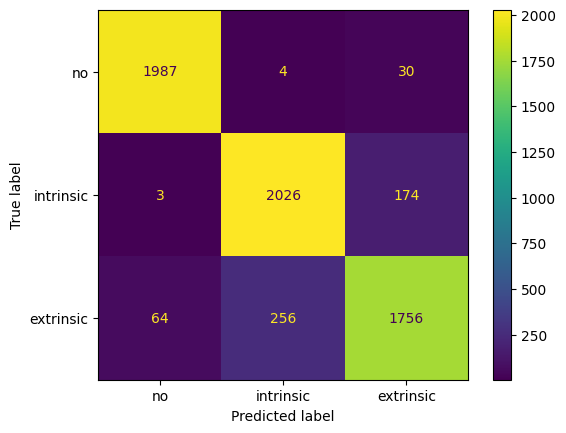

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on the training set
train_preds, train_trues = [], []
final_model.eval() # Ensure model is in evaluation mode
with torch.no_grad():
    for batch in tqdm(train_loader, desc="Predicting on train set"):
        for k in ["pr_ids","pr_mask","ev_ids","ev_mask","mass","labels"]:
            if k in batch: batch[k] = batch[k].to(CFG.device)
        out = final_model(batch)
        logits = out if isinstance(out, torch.Tensor) else out[0]
        pred = logits.argmax(-1).detach().cpu().tolist()
        train_preds.extend(pred)
        train_trues.extend(batch["labels"].detach().cpu().tolist())

# Compute confusion matrix
cm = confusion_matrix(train_trues, train_preds)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no", "intrinsic", "extrinsic"])
disp.plot()
plt.show()

In [21]:
@torch.no_grad()
def predict_logits_no_temp(model, loader):
    model.eval()
    all_ids, all_logits = [], []
    for b in loader:
        for k in ["pr_ids","pr_mask","ev_ids","ev_mask","mass"]:
            b[k] = b[k].to(CFG.device)
        logits = model(b) # No temperature scaling applied
        all_logits.append(logits.detach().cpu())
        all_ids += b["id"]  # id thật
    return torch.cat(all_logits, 0), all_ids

# Predict without temperature scaling
logits_te_no_temp, ids_te_no_temp = predict_logits_no_temp(final_model, test_loader)
pred_te_no_temp   = logits_te_no_temp.argmax(-1).numpy().tolist()
labels_te_no_temp = [ID2LABEL[int(x)] for x in pred_te_no_temp]

# Build submission & sanity checks
sub_no_temp = pd.DataFrame({CFG.id_col: ids_te_no_temp, "predict_label": labels_te_no_temp})
sub_no_temp[CFG.id_col] = sub_no_temp[CFG.id_col].astype(str)

assert len(sub_no_temp) == len(test_raw), f"Số dòng submit ({len(sub_no_temp)}) != test_raw ({len(test_raw)})"
assert set(sub_no_temp[CFG.id_col]) == set(test_raw[CFG.id_col].astype(str)), "Tập id trong submit không khớp test_raw."

# Save submission without temperature scaling
csv_path_no_temp = os.path.join(CFG.outdir, "submit_no_temp.csv")
sub_no_temp.to_csv(csv_path_no_temp, index=False)
print("Saved submission CSV without temperature scaling:", csv_path_no_temp)
display(sub_no_temp.head())

# Zip the submission file
zip_path_no_temp = os.path.join(CFG.outdir, "submit_no_temp.zip")
with zipfile.ZipFile(zip_path_no_temp, "w", zipfile.ZIP_DEFLATED) as zf:
    zf.write(csv_path_no_temp, arcname="submit.csv")
print("Zipped submission without temperature scaling:", zip_path_no_temp)

Saved submission CSV without temperature scaling: /kaggle/working/final_classifier/submit_no_temp.csv


,id,predict_label
0,ef35e7a1-766f-4455-b349-09084a1f56ba,no
1,85aac4aa-e53c-4d01-bdcf-e8b27a2cd9bc,intrinsic
2,cd056e1b-51f6-4adf-939c-e742645437bf,no
3,6cc80aa4-44db-4366-8cb6-16453aa8ecbf,intrinsic
4,948849cb-0c83-4dc1-b5ae-aaa585a8d528,intrinsic


Zipped submission without temperature scaling: /kaggle/working/final_classifier/submit_no_temp.zip


In [22]:
# Lưu model, cấu hình, mapping
torch.save(final_model.state_dict(), os.path.join(CFG.outdir, "final_model.pt"))
json.dump({
    "pretrained": CFG.pretrained_cls,
    "LABEL2ID": LABEL2ID, "ID2LABEL": ID2LABEL,
    "T": float(T_cls) if 'T_cls' in globals() else 1.0, # Save temperature if calculated, otherwise 1.0
    "cfg": {k:getattr(CFG,k) for k in CFG.__dataclass_fields__.keys()}
}, open(os.path.join(CFG.outdir, "final_meta.json"), "w"), ensure_ascii=False, indent=2)

# Save evaluation metrics
metrics_path = os.path.join(CFG.outdir, "evaluation_metrics.json")
eval_metrics = {
    "macro_f1": f1,
    "accuracy": acc,
    "classification_report": classification_report(tr, pr, target_names=[k for k,_ in sorted(LABEL2ID.items(), key=lambda x:x[1])], output_dict=True)
}
json.dump(eval_metrics, open(metrics_path, "w"), ensure_ascii=False, indent=2)
print("Saved evaluation metrics:", metrics_path)

print("Saved:", CFG.outdir)

Saved evaluation metrics: /kaggle/working/final_classifier/evaluation_metrics.json
Saved: /kaggle/working/final_classifier


In [25]:
# Cần thêm dataset chứa file /kaggle/input/kaggle-json/kaggle.json
import subprocess, shutil, stat

DATA_DIR = CFG.outdir
META = {
  "title": "Artefacts Final",
  "id": "honghien123/ArtefactModel-ce-gate-pipeline-v3",
  "licenses": [{"name": "CC0-1.0"}],
  "isPrivate": True
}
open(os.path.join(DATA_DIR, "dataset-metadata.json"), "w").write(json.dumps(META, ensure_ascii=False, indent=2))

def run(cmd):
    r = subprocess.run(cmd, capture_output=True, text=True)
    print(r.stdout or r.stderr)
    return r.returncode

try:
    os.makedirs("/root/.kaggle", exist_ok=True)
    shutil.copy("/kaggle/input/kaggle-json-2/kaggle.json", "/root/.kaggle/kaggle.json")
    os.chmod("/root/.kaggle/kaggle.json", stat.S_IRUSR | stat.S_IWUSR)
    rc = run(["kaggle", "datasets", "create", "-p", DATA_DIR, "-r", "zip"])
    if rc != 0:
        run(["kaggle", "datasets", "version", "-p", DATA_DIR, "-m", "update"])
except Exception as e:
    print("Skip Kaggle CLI publish:", e)

Starting upload for file submit_no_temp.csv
Upload successful: submit_no_temp.csv (88KB)
Starting upload for file final_meta.json
Upload successful: final_meta.json (1KB)
Starting upload for file final_model.pt
Upload successful: final_model.pt (1GB)
Starting upload for file submit_no_temp.zip
Upload successful: submit_no_temp.zip (44KB)
Starting upload for file final_best.pt
Upload successful: final_best.pt (1GB)
Starting upload for file submit.zip
Upload successful: submit.zip (44KB)
Starting upload for file submit.csv
Upload successful: submit.csv (88KB)
Starting upload for file cls_temp.json
Upload successful: cls_temp.json (25B)
Starting upload for file evaluation_metrics.json
Upload successful: evaluation_metrics.json (944B)
Your private Dataset is being created. Please check progress at https://www.kaggle.com/datasets/honghien123/ArtefactModel-ce-gate-pipeline-v3

